## Using MELTS to find the liquidus temperature

- Finding the liquidus temperature of a magma is one of the first steps of most crystallisation and/or decompression calculations.
- Usually this command is used as part of the isobaric_crystallisation and isothermal_decompression functions (amongst others).
- However, it's still useful to consider how the liquidus function works independently, and examine how well MELTS performs as a Thermometer in igneous systems.

**Before any calculations can be run** users need to download and install the alphaMELTS for Python files. This can be easily achieved with one simple function, please see the installation guide available on ReadTheDocs.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/LiquidusTests/MELTS_MAGEMin_Liquidus.xlsx

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import petthermotools as ptt
from tqdm.notebook import tqdm, trange
# import pickle

# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
# import sys
# sys.path.append(r'path_to_alphaMELTS_files')

In [4]:
import platform
if platform.system() == "Darwin":
    # used to suppress MELTS outputs in MacOS systems (run twice)
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

To test the ability of MELTS to act as a liquid-only thermometer we need some experiments to test them against. Here, we use a database of experimental data compiled by P. Wieser (Wieser et al. 2025). 

In [5]:
Data = pd.read_excel('MELTS_MAGEMIN_Liquidus.xlsx')

The entire experimental dataset contains over 2000 samples. Therefore, to reduce the computational time in this example I isolate 200 experiments (randomly selected) to be used in the following calculations. A new DataFrame is constructed using only these experiments.

In [6]:
# randomly select 200 rows from the original DataFrame
Ch = np.random.choice(range(len(Data['SiO2_Liq'])), 200, replace=False)
Test = Data.copy()
Test = Test.loc[Ch]

# reset the index in the new DataFrame
Test = Test.reset_index(drop = True)

Now that we have this 'Test' DataFrame we can use the findLiq_multi function to identify the liquidus temperature of each sample. Ideally, we'd have information about either the Fe redox state or an estimate of the oxygen fugacity of each melt. Unfortunately, we don't have this information for every sample so instead we will define a constant Fe$^{3+}$/Fe$_{tot}$ ratio for all samples:

In [7]:
Results_pMELTS = ptt.findLiq_multi(Model = "pMELTS", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

  0%|          | 0/25 [00:00<?, ?it/s]

Examining the results reveals the information that is recorded by this function. Notably, the findLiq_multi code will return the composition of the melt at the liquidus (in wt% hydrous normalized), whether or not the melt is fluid saturated at the liquidus, the liquidus phase, and (critically) the liquidus temperature (in degrees Celsius).

In [8]:
Results_pMELTS.head()

,T_Liq,liquidus_phase,fluid_saturated,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq
0,1192.65,olivine1,No,50.480467,0.747859,16.925225,0.0,10.036120,0.167284,7.537629,10.332259,1.830286,0.305048,0.000000,1.637823,0.0,0.149921
1,1176.15,olivine1,No,50.768865,0.915020,17.218123,0.0,10.920196,0.157423,6.109974,9.573276,2.262953,0.452591,0.000000,1.621578,0.0,0.149921
2,1072.75,clinopyroxene1,No,64.247289,0.503900,15.601529,0.0,3.369691,0.087214,2.112505,4.864576,4.418818,1.376035,0.155046,3.263396,0.0,0.149921
3,1036.15,clinopyroxene1,No,62.560557,0.504295,16.109414,0.0,3.511059,0.084049,1.158010,3.828904,4.249150,1.316769,0.074710,6.603083,0.0,0.149921
4,1005.85,clinopyroxene1,No,62.272831,0.489892,16.863596,0.0,3.208168,0.084789,1.215309,4.032189,4.418451,1.281256,0.169578,5.963940,0.0,0.149921


In this initial calculation, the liquidus temperature is calculated using the pMELTS model, which was designed for use on mantle-like bulk compositions at 1 - 3 GPa (Ghiorso et al. 2002). For the majorty of samples in this database it may be more appropriate to use the rhyoliteMELTSv1.0.2 (Gualda et al. 2012) or rhyoliteMELTSv1.2.0 (Ghiorso and Gualda, 2015) models. We can rerun the same calculations but change the Model selected:

In [9]:
Results_MELTSv102 = ptt.findLiq_multi(Model = "MELTSv1.0.2", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
Results_MELTSv102.head()

,T_Liq,liquidus_phase,fluid_saturated,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq
0,1202.15,orthopyroxene1,No,50.480467,0.747859,16.925225,0.0,10.036120,0.167284,7.537629,10.332259,1.830286,0.305048,0.000000,1.637823,0.0,0.149921
1,1229.35,orthopyroxene1,No,50.768865,0.915020,17.218123,0.0,10.920196,0.157423,6.109974,9.573276,2.262953,0.452591,0.000000,1.621578,0.0,0.149921
2,1112.55,orthopyroxene1,No,64.247289,0.503900,15.601529,0.0,3.369691,0.087214,2.112505,4.864576,4.418818,1.376035,0.155046,3.263396,0.0,0.149921
3,1061.45,orthopyroxene1,No,62.560557,0.504295,16.109414,0.0,3.511059,0.084049,1.158010,3.828904,4.249150,1.316769,0.074710,6.603083,0.0,0.149921
4,1031.85,orthopyroxene1,No,62.272831,0.489892,16.863596,0.0,3.208168,0.084789,1.215309,4.032189,4.418451,1.281256,0.169578,5.963940,0.0,0.149921


In [11]:
Results_MELTSv120 = ptt.findLiq_multi(Model = "MELTSv1.2.0", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
Results_MELTSv120.head()

,T_Liq,liquidus_phase,fluid_saturated,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq
0,1181.05,orthopyroxene1,No,50.480467,0.747859,16.925225,0.0,10.036120,0.167284,7.537629,10.332259,1.830286,0.305048,0.000000,1.637823,0.0,0.149921
1,1210.35,clinopyroxene1,No,50.768865,0.915020,17.218123,0.0,10.920196,0.157423,6.109974,9.573276,2.262953,0.452591,0.000000,1.621578,0.0,0.149921
2,1082.65,orthopyroxene1,No,64.247289,0.503900,15.601529,0.0,3.369691,0.087214,2.112505,4.864576,4.418818,1.376035,0.155046,3.263396,0.0,0.149921
3,1057.45,garnet1,No,62.560557,0.504295,16.109414,0.0,3.511059,0.084049,1.158010,3.828904,4.249150,1.316769,0.074710,6.603083,0.0,0.149921
4,1013.95,garnet1,No,62.272831,0.489892,16.863596,0.0,3.208168,0.084789,1.215309,4.032189,4.418451,1.281256,0.169578,5.963940,0.0,0.149921


Now that we have the results of this analysis, we can compare the results of these calculations to the true experimental temperature. Experiments that have no reported water typically show a very poor match to the experimental temperature, and are thus excluded from the following comparison. Additionally, we exlude any calculations that did not return a result (Results['T_C_liq'] = 0).

Overall, MELTS does an acceptable job in reproducing the experimental temperatures, although it is notable that the liquidus temperature is typically overpredicted by around 50 $^{o}$C.

Text(800, 1460, 'rhyoliteMELTSv1.2.0')

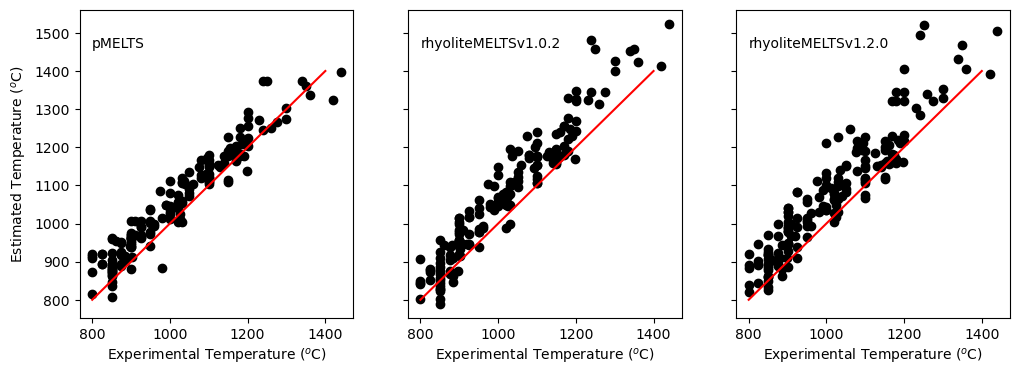

In [13]:
f, a = plt.subplots(1,3, figsize = (12,4), sharex = True, sharey = True)

a[0].plot(Test['T_K'][(Test['H2O_Liq'] > 0) & (Results_pMELTS['T_Liq'] > 0)]-273.15,
       Results_pMELTS['T_Liq'][(Test['H2O_Liq'] > 0) & (Results_pMELTS['T_Liq'] > 0)], 
        'ok')
a[0].plot([800,1400],[800,1400], 'r-')
a[0].set_ylabel('Estimated Temperature ($^{o}$C)')
a[0].set_xlabel('Experimental Temperature ($^{o}$C)')
a[0].text(800, 1460, 'pMELTS')


a[1].plot(Test['T_K'][(Test['H2O_Liq'] > 0) & (Results_MELTSv102['T_Liq'] > 0)]-273.15,
       Results_MELTSv102['T_Liq'][(Test['H2O_Liq'] > 0) & (Results_MELTSv102['T_Liq'] > 0)], 
        'ok')
a[1].plot([800,1400],[800,1400], 'r-')
a[1].set_xlabel('Experimental Temperature ($^{o}$C)')
a[1].text(800, 1460, 'rhyoliteMELTSv1.0.2')


a[2].plot(Test['T_K'][(Test['H2O_Liq'] > 0) & (Results_MELTSv120['T_Liq'] > 0)]-273.15,
       Results_MELTSv120['T_Liq'][(Test['H2O_Liq'] > 0) & (Results_MELTSv120['T_Liq'] > 0)], 
        'ok')
a[2].plot([800,1400],[800,1400], 'r-')
a[2].set_xlabel('Experimental Temperature ($^{o}$C)')
a[2].text(800, 1460, 'rhyoliteMELTSv1.2.0')